In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

Смоделировать игру против лотерейного автомата типа “777”. Игрок платит 1 руб., после чего выпадает случайное целое число, равномерно распределенное от 0 до 999. При некоторых значениях числа игрок получает выигрыш.  

- 777: 200 руб.
- 999: 100 руб.
- 555: 50 руб.
- 333: 15 руб.
- 111: 10 руб.
- *77: 5 руб.
- **7: 3 руб.
- *00: 2 руб.
- **0: 1 руб.

Вопросы:  

Выгодна ли игра игроку?  
Сколько в среднем приобретает или теряет игрок за одну игру?  

### Монте-Карло

Напишем функцию имитирующую один поворот рычага аппарата для получения суммы выигрыша при каждом из исходов

In [2]:
def one_turn():
    res = np.random.randint(low=0, high=1000, size=1)
    if res == 777:
        win = 200
    elif res == 999:
        win = 100
    elif res == 555:
        win = 50
    elif res == 333:
        win = 15
    elif res == 111:
        win = 10
    elif res % 100 == 77: # 777 сюда уже не попадут
        win = 5
    elif res % 10 == 7: # 777, 77, 177, .... 977 сюда уже не попадут
        win = 3
    elif res % 100 == 0:
        win = 2
    elif res % 10 == 0:
        win = 1
    else:
        win = 0
    return win - 1

Сколько раз он выиграл денег при 1000000 экспериментах


,money,times
0,-1,796329
1,0,90190
2,1,9968
3,2,89425
4,4,9012
5,9,1002
6,14,1060
7,49,1030
8,99,998
9,199,986


Средний выигрыш составил: -0.20212, если экперимент повторить 1000000 раз


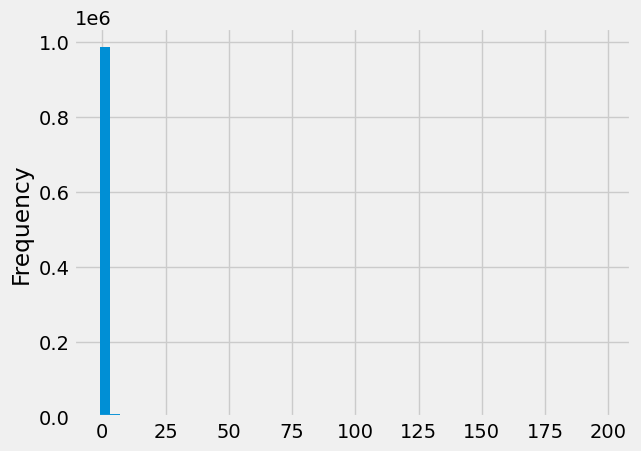

In [3]:
n = 1000000
win_se = pd.Series(([one_turn() for _ in range(n)])).rename('times')
print(f'Сколько раз он выиграл денег при {n} экспериментах')
win_df = win_se.value_counts().sort_index(ascending=True).to_frame().rename_axis('money').reset_index()
display(win_df)
print(f'Средний выигрыш составил: {round(win_se.mean(), 5)}, если экперимент повторить {n} раз')
win_se.plot(kind='hist', bins=50)
plt.show()

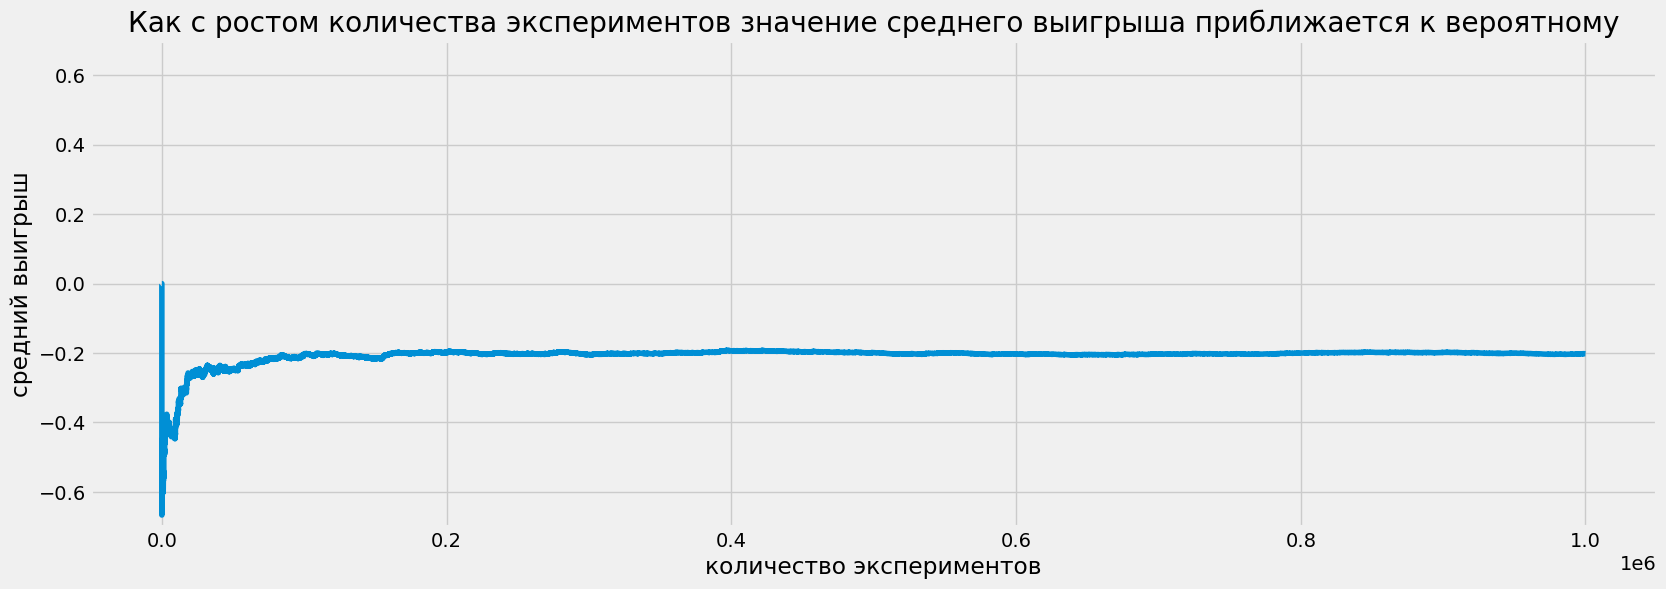

In [4]:
plt.figure(figsize=(18,6))
(win_se.cumsum() / (win_se.index + 1)).plot()
plt.title('Как с ростом количества экспериментов значение среднего выигрыша приближается к вероятному')
plt.xlabel('количество экспериментов')
plt.ylabel('средний выигрыш')
plt.ylim(-.7, .7)
plt.show()

Графически эксперименты выглядят правдоподобно. Сперва средний выигрыш сильно скачет, но чем дальше, тем он стабильней фиксируется в районе минус 20 коп.

### Расчет

Пропишем вероятности каждого выигрыша. Вероятность проигрыша рассчитаем в цикле как 1 - сумма вероятностей выигрышей

In [5]:
chance = (
    [0.001, 200], # 777 -- 1 / 1000
    [0.001, 100], # 999 -- 1 / 1000
    [0.001, 50], # 555 -- 1 / 1000
    [0.001, 15], # 333 -- 1 / 1000
    [0.001, 10], # 111 -- 1 / 1000
    [0.009, 5], # *77 -- (10-1) / 1000 (77, 177, 277, 377,.... 977) без 777, т.к. это другой исход
    [0.09, 3], # **7 -- (100-10) / 1000 (7, 17, 27,....997) без предыдущих
    [0.009, 2], # *00 -- 9 / 1000 (100, 200, 300, 400,.... 900)
    [0.09, 1]) # **0 -- (99-9) / 1000 (10, 20, 30, 40,.... 990 ) без предыдущих

In [6]:
money = 0
fail = 1
for i in chance:
    fail -= i[0]
    money += (i[0] * (i[1] - 1))
print(f'Вероятность ничего не выиграть {fail}') 
print(f'Средний выигрыш составил {round(money + (fail * - 1), 5)}')

Вероятность ничего не выиграть 0.797
Средний выигрыш составил -0.202


Вероятность проигрыша соответствует числу проигрышей из симуляции __795598__ раз из __1 млн__ случаев.